## Accurate Uncertainties for Deep Learning Using Calibrated Regression

**Authors**: *Anthony Rentsch* and *Abhimanyu Vasishth*

This notebook contains an implementation and overview of the [2018 paper](https://arxiv.org/abs/1807.00263) by Kuleshov et al. [1]


### Table of Contents

1. [Prolem Statement](#problem_statement)
2. [Background](#background)
3. [Existing work](#existing_work)
4. [Contribution](#contribution)
5. [Technical Content](#technical_content)
6. [Experiments and Evaluation](#experiments_and_evaluation)
   1. [Experiment 1: Calibrating a misspecified model](#experiment1)
   2. [Experiment 2: Calibrating a correctly specified model](#experiment2)
   3. [Experiment 3: Calibrating under epistemic uncertainty](#experiment3)
   4. [Experiment 4: Calibrating when the training data differs from the test data (dataset shift)](#experiment4)
7. [Future work](#future_work)
8. [References](#references)

In [1]:
# import modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# source files
import sys
sys.path.append('scripts/')
from scripts.calibrated_regression import CalibratedRegression
from scripts.data_loader import load_quadratic_data

import pymc3 as pm

# plotting
import seaborn as sns
sns.set_style('white')
%matplotlib inline

<a id='problem_statement'></a>
### Problem Statement 

---

It is often desirable in statistical modeling and machine learning to obtain accurate estimates of the uncertainty associated with predictions, especially when these models are used in highly sensitive decision-making contexts. What are accurate estimates of uncertainty? One useful criteria is known as **calibration**. Consider these two motivating examples:

- In the classification setting, if we predict that an individual will exhibit some behavior with 30% probability it would be desirable for the long-term frequency of this individual exhibiting this behavior to actually be 30%.
- In the regression setting, it would be desirable for a 95% predictive interval to actually contain 95% of observations. 

If we meet this criteria in either setting, we would call our predictions **well-calibrated**. However, many types of algorithms do not produce well-calibrated predictions out-of-the-box. While this is well-understood in classification, there is room for improvement with respect to calibrating predictive intervals for regression. This paper provides a model-agnostic, post-modelling algorithm to calibrate predictive intervals.

<a id='background'></a>
### Background

---

Machine learning is increasingly being used to inform decision-making processes in the private and public sectors alike. Often, decision-makers desire predictive models that can help them prioritize how they use their scarce resources. Which pieces of equipment need to be inspected first? To which houses should our campaign send volunteer canvassers? What applications should we review first, or at all?

These use cases often only ask that the model correctly rank-order the entities of interest. We only care that something is more likely to happen to person A than to person B, but we do not really care how wrong we might be about any one prediction.

In highly sensitive decision-making or planning contexts, however, it is important to have realistic estimates of uncertainty. Think about a doctor prescribing a drug to a patient, an elected official crafting new policies designed to provide resources to constituents, or a financial analyst investing funds into different markets, or a meteorologist trying to accurately predict the probability of rain the next day. In these cases, we want to know how wrong we could be because the consequences of being wrong could be catastrophic.

Take an example from a project that Anthony worked on this semester. Working with the City of Somerville, his team trained a machine learning model to predict which houses in the city had driveways, a piece of information that city officials did not already have but wanted to have to do transportation planning around new infrastructure projects and emissions goals. Since they only provided the City of Somerville estimates of which houses had driveways, rather than a full census, they wanted to accurately convey the uncertainty around these estimates. When they said there is a 75% chance that a house has a driveway, they wanted that to be true roughly 75% of the time. In turn, these well-calibrated probabilities allow city officials to accurately estimate parking capacity in small subsets of the city. Here, calibration allows for a nuanced approach to urban planning.

<a id='existing_work'></a>
### Existing Work

---

Existing work has been divided into two categories: model-aware methods and model-agnostic methods.

#### Model-Aware Methods

Lakshminarayanan et al. [2] propose a method by which they modify the training pipeline of Bayesian Neural Networks to avoid miscalibrated uncertainty estimates on new test data that could differ from the data it was trained on (a problem that is known as dataset shift). The proposed method of training involves a combination of ensembles and adversarial training. Another model-aware method that is particular to Bayesian Neural Networks is a method called Monte Carlo dropout, proposed by Gal et al. [3] This is a theoretical approach that approximates dropout in Bayesian Neural Networks as Bayesian inference and uses dropout to approximate uncertainty, thereby obtaining more accurate predictions for uncertainty without sacrificing tremendous computational power to correct the model.

#### Model-Agnostic Methods

Existing work also attempt to treat the model being calibrated as a black-box and apply general principles of calibration to any uncalibrated model. A famous example of this idea is Platt scaling [4], that applies calibration as a post-processing step to Support Vector Machines. This technique, however, only applies to classification models. 

<a id='contribution'></a>
### Contribution

---

The paper’s main contribution is an algorithm that can be used to recalibrate predictive intervals from regression models, particularly Bayesian models. This algorithm is unique in that it:

1. is a post-modelling step, which means that it is model agnostic
2. only requires that the model output a cumulative distribution function (CDF) for each observation, which can be done in non-Bayesian ways if desired, such as by using the predictive interval of a frequentist linear regression model by bootstrapping


<a id='technical_content'></a>
### Technical Content

---

The algorithm that the authors propose is fairly simple but it takes some effort to understand what it is doing and why. We start by stating the algorithm verbatim from the paper and then walk through the intuition and technical details behind it

<img src="images/algorithm1.png" alt="algorithm1" width="400"/>

The intuition behind the author’s recalibration algorithm is to record where each observation lies with respect to the model’s predicted distribution for that point, compare that value to the predicted distributions for all the other observations, and then map each individual observation’s distribution so that it is in line with what the distribution across observations would have predicted. This mapping is used to transform the desired quantiles of the predicted interval in such a way that produces a predictive interval that is better calibrated based on the distribution of values across observations.

Generally, this is broken up into two components: (1) creating the recalibration dataset and (2) fitting and applying the calibration model.

#### Recalibration dataset

Let’s consider a regression model $H$ (this is referred to as the forecaster in the paper) that takes in inputs $X$ and predicts outputs $y$. $H$ outputs a probability distribution for each observation, either naturally in the Bayesian setting or through something like bootstrapping in the frequentist setting. This is typically referred to as the posterior predictive distribution. From this distribution, we can obtain a cumulative distribution function $F_t$ and evaluate it at the $y$ value for that observation. All of this is visualized in the plot below.

![Sketch of algorithm](images/regression_cdf_plot.png)

Why is this important or useful? First we need to define what it means to be calibrated in the regression setting. Formally, the authors say that a regression model is calibrated if

$$
\begin{aligned} 
\frac{\sum_{t=1}^T | \mathbb{I}\{y_t \leq F^{-1}(p)\} | }{T} \rightarrow p \quad \text{for all} p \in [0, 1]
\end{aligned}
$$

where $T$ is the number of data points, $F_t^{-1}$ is the inverse of $F_t$, and $p$ is the confidence level. 
If we let $p=90$, for example, this implies that 90% of our observations should fall below the 90% quantile of the CDF that the model outputs for each observation in order for the model to be calibrated. Thus, our first step is to measure where each observation $y_t$ falls in the CDF $F_t$ that $H$ outputs for $t$. The authors denote this $[H(x_t)](y_t)$.

We are not just interested as to whether each observation falls under the 90% quantile of the CDF at that corresponding $t$. We are interested in whether 90% of our observations fall under the 90% quantiles of their CDFs. It is useful to think of this distinction as the CDF for a single observation and the CDF across all observations. 

Now we need to calculate the CDF across all observations. Since we want to compare each observation to all other observations, we count the number of other observations for which the value of the CDF for that observation is less than or equal to the value of the CDF for the observation of interest. This is denoted $\hat{P}([H(x_t)](y_t))$. For instance, let $F_1(y_1) = 0.6$ and $\hat{P}([H(x_t)](y_t)) = 0.9$. This means that, while $y_1$ lies at the 60% quantile for its individual CDF it lies at the 90% quantile of the CDF across all observations.
We now have the recalibration set $D = \{ [H(x_t)](y_t), \hat{P}([H(x_t)](y_t)) \}$ where the independent variable is the value of the CDF for each observation and the dependent variable is the value of the across observation CDF for each observation.

#### Calibration model

In this section and the next, we refer to $H(x_t)(y_t)$ as the predicted cumulative distribution and $\hat{P}([H(x_t)](y_t))$ as the empirical cumulative distribution. An example plot illustrating these two quantities is shown below: 

<img src="images/calibration_model.png" alt="calibration model" width="600"/>

In the plot above, the grey line represents perfect calibration, as this means that all points with a predicted cumulative distribution value of $\leq p$, where $p \in [0,1]$ occur in the dataset with a ratio of $\leq p$. We also see that in this example, our model is quite uncalibrated: several points are predicted to have a cumulative distribution value of close to 1 or close to 0, which indicates that the predicted intervals are too narrow. 

The authors suggest that the next step of the algorithm is to fit a model, such as **Isotonic Regression**, to the above set of points. Isotonic Regression is a good candidate for this problem for a few reasons: 

1. The regression line fit is a free-form line: this captures the variation we see in the plot of predicted vs empirical cumulative distribution and does not force fit a straight line onto the points.
2. The fitted free-form line has to be non-decreasing everywhere: this is an important caveat as, intuitively, there will be more points that have a predicted cumulative distribution of less than or equal to 0.8 than there will be points that have a predicted cumulative distribution of less than or equal to 0.5, for example. Having a fitted free-form line that respects this constraint is crucial to calibration.
3. Isotonic Regression fits a free-form line that has to be as close as possible to the observations. 

We fit an Isotonic Regression on our calibration dataset $D$ such that a desired empirical distribution value is input and the corresponding predicted distribution value is output.

#### Prediction

Let us take a concrete example of a 90% predictive interval, which requires us to compute the 0.05 and 0.95 quantiles of the posterior predictive, in a Bayesian regression setting. We would like the empirical quantiles to be 0.05 and 0.95 in order for our model to be perfectly calibrated. We input 0.05 and 0.95 into our model and obtain the values for the predicted cumulative distribution that would result in empirical cumulative distribution values of 0.05 and 0.95 respectively. This is shown in the figure below: 

<img src="images/calibration_model_lines.png" alt="calibration model lines" width="600"/>

We then calibrate our predictive interval by using these quantiles $[0.016, 0.986]$ instead. We can see that these quantiles will result in a wider predictive interval. 

#### Implementation Details

Since the paper did not come with source code, we implemented a `CalibratedRegression` class (in the `scripts` directory) that contains the necessary functions to create a calibration dataset, fit an Isotonic Regression model onto this dataset and create diagnostic plots for the model. We use two metrics to evaluate calibration: 

1. Percentage of points inside the prediction interval: intuitively, we want 90% of the points in the test dataset to fall in the 90% prediction interval, for instance, so we use this metric to evaluate model calibration
2. Mean Squared Error (MSE): the authors claim that calibration does not sacrifice test accuracy and we want to use MSE as a metric to compare the fit of the uncalibrated model and the calibrated model

Finally, we use PyMC3 to sample from our Bayesian Model. By default, the implementation of PyMC3 uses No U-Turn Sampling (NUTS).

<a id='experiments_and_evaluation'></a>
### Experiments and Evaluation

---

In the paper, the authors perform a number of experiments on traditional regression tasks using Bayesian linear regression and Bayesian neural networks; a depth estimation task using a Bayesian convolutional neural network; a time series task using a Bayesian recurrent neural network; and a model-based reinforcement learning task. While these experiments are designed to showcase the recalibration algorithm’s broad utility, we think that it is more useful to examine a few simple Bayesian regression cases to see when this technique is useful and when it is not. The experiments we run are listed below: 

1. Calibrating a misspecified model
2. Calibrating a correctly specified model
3. Calibrating under epistemic uncertainty
4. Calibrating when the training data differs from the test data (dataset shift)

<a id='experiment1'></a>
#### Experiment 1: Calibrating a misspecified model

In this experiment, we first generate a set of 1500 points (1250 training and 250 points) of the following form (the code for generating these points is in our `scripts` directory in the file `data_loader.py`: 
$$
\begin{aligned}
x &\in [-10,10] \\
y &= p x^2 + \epsilon, \epsilon \sim \mathcal{N}(0,2)
\end{aligned}
$$
$y$ is a quadratic function of $x$ with some noise that comes from a Normal Distribution with  a standard deviation of 2. The data is shown below: 

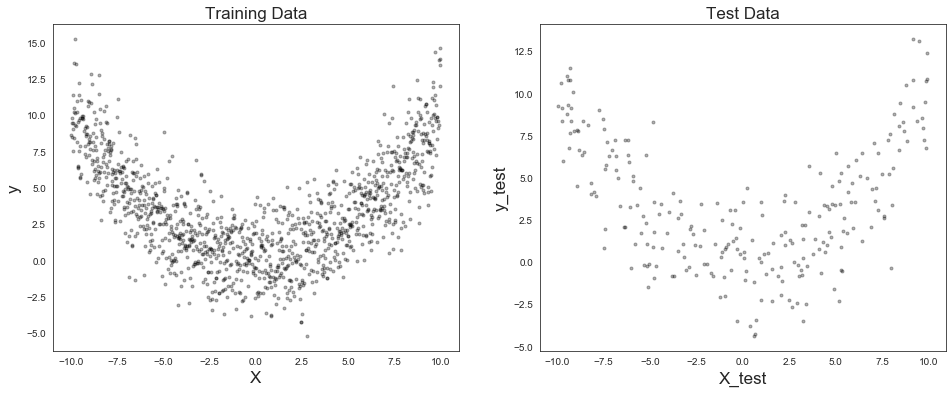

In [2]:
X, X_test, y, y_test = load_quadratic_data()

# plotting X and y and X_test and y_test
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

ax[0].set_title('Training Data', fontsize=17)
ax[0].plot(X, y, 'o', markersize=3, color='black', alpha=0.3)
ax[0].set_xlabel('X', fontsize=17)
ax[0].set_ylabel('y', fontsize=17)

ax[1].set_title('Test Data', fontsize=17)
ax[1].plot(X_test, y_test, 'o', markersize=3, color='black', alpha=0.3)
ax[1].set_xlabel('X_test', fontsize=17)
ax[1].set_ylabel('y_test', fontsize=17);

Looking at this data, one may propose a quadratic function to model the data. However, we do not know the true data distribution during modeling, so it is very easy to incorrectly specify certain parameters of the model. In this case, we incorrectly specify the noise of our model, which is as follows: 

$$
\begin{aligned}
a &\sim \mathcal{N}(0,1) \\
b &\sim \mathcal{N}(0,1) \\
c &\sim \mathcal{N}(0,1) \\
\hat{y} &\sim \mathcal{N}(ax^2 + bx + c, \sigma=1) \\
\end{aligned}
$$

Next, we simulate points using `pymc3`. 

In [3]:
with pm.Model() as model_misspecified:
    a = pm.Normal('a', mu=0, sigma=1)
    b = pm.Normal('b', mu=0, sigma=1)
    c = pm.Normal('c', mu=0, sigma=1)
    
    f = a*X**2 + b*X + c
    y_obs = pm.Normal('y', mu=f, sigma=1, observed=y)
    
    trace = pm.sample(1000, tune=1000)
    
pm.summary(trace)

def posterior_predictive(x, a, b, c, sigma=1):
    '''Returns samples from posterior predictive.
    
    Parameters
    ----------
    x : array-like
        Data
    a : np.array
        Posterior samples of a
    b : np.array
        Posterior samples of b
    c : np.array
        Posterior samples of c
    sigma : float
        Standard deviation of observation noise
            
    Returns
    -------
    samples : np.array
    '''
    x, a, b, c = x.reshape(-1,1), a.reshape(-1,1), b.reshape(-1,1), c.reshape(-1,1)
    noise = np.random.normal(scale=sigma, size=a.shape[0])
    samples = (x**2).dot(a.T) + x.dot(b.T) + np.ones(x.shape).dot(c.T) + noise
    return samples

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [c, b, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:04<00:00, 908.69draws/s] 


We create the calibration dataset according to Algorithm 1 of the paper and plot the predicted cumulative distribution versus the empirical cumulative distribution as follows: 

,X,y,predicted_cdf,empirical_cdf
0,-0.166778,-0.738170,0.187,0.344
1,-6.144096,2.375789,0.062,0.216
2,-8.212141,6.063325,0.231,0.388
3,2.941961,4.041305,1.000,1.000
4,-6.050700,4.140914,0.637,0.616


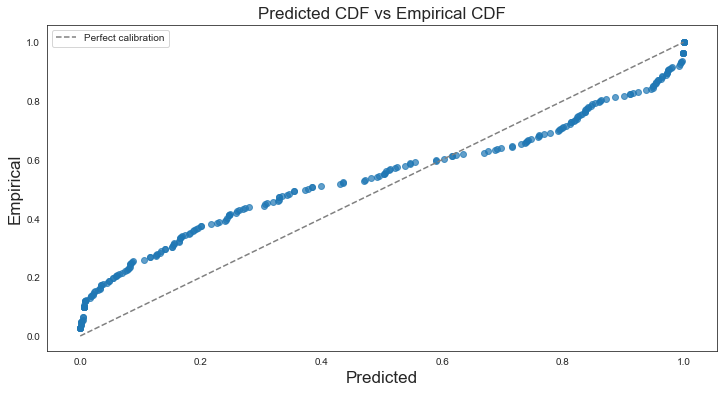

In [4]:
a, b, c = trace['a'][:-1000], trace['b'][:-1000], trace['c'][:-1000]

# fitting the calibrated regressor
pp_params = {'a': a, 'b': b, 'c': c}
calib = CalibratedRegression(X, y, model_misspecified, pp=posterior_predictive, pp_params=pp_params).fit()

# creating the results dataframe
df_results, pred_cdf, emp_cdf = calib.create_calibration_dataset()
display(df_results.head())

# getting quantiles
quants = [0.05, 0.5, 0.95]

# plotting calibration curve
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
calib.plot_calibration_curve(ax);

We see, from the plot above, that the model is far from being perfectly calibrated. Many points have a predicted cumulative distribution value of close to 0 or close to 1: this indicates that the predictive interval is too narrow. We have already fit an Isotonic Regression to the above plot, when we called the `fit` function of our `CalibratedRegression` class, and we see the results of calibration in the following plot: 

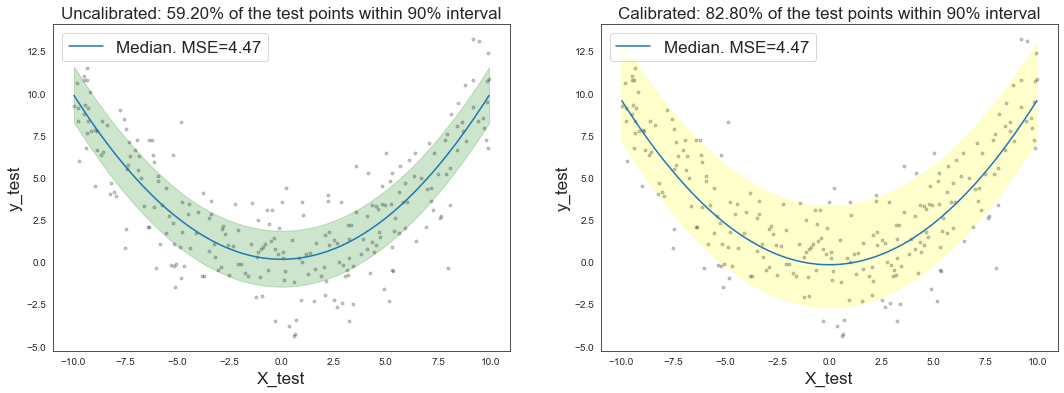

In [5]:
# checking new posterior predictive intervals
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
calib.plot_intervals(ax, X_test, y_test, quantiles=[0.05, 0.5, 0.95]);

After calibration, the resulting intervals are wider. The percentage of points in the 90% interval is a lot closer to 90% of the points, without a significant loss in MSE. The diagnostic plot recommended by the authors is shown below:

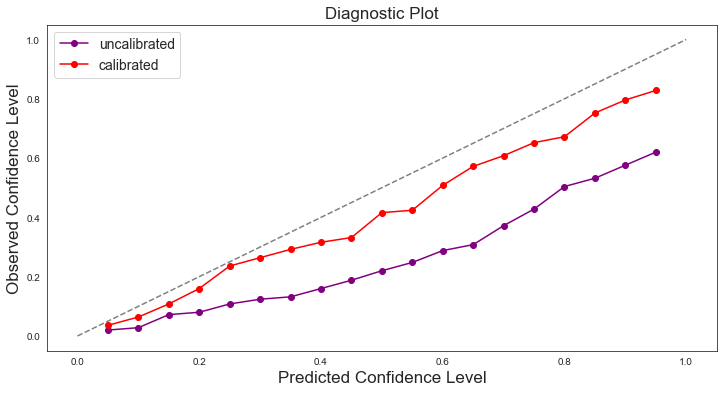

In [6]:
fig, ax = plt.subplots(1,1,figsize=(12,6))
calib.plot_diagnostic_curve(ax, X_test, y_test);

**Evaluation:** The two plots above illustrate the main strength of the paper: successfully calibrating models when they have not been perfectly specified. We see that the resulting model fit is not too different, which results in a similar MSE score, but the uncertainties have been calibrated such that the true percentage of test set points in the 90% interval is a lot closer to 90%, as desired.

<a id='experiment2'></a>
#### Experiment 2: Calibrating a correctly specified model

In this experiment, we use the training and test set generated in experiment 1. We modify the $\sigma$ term of the model such that both the true data generation function as well as the model use the same value of $\sigma$, which is 2. The model is specified as follows: 

$$
\begin{aligned}
a &\sim \mathcal{N}(0,1) \\
b &\sim \mathcal{N}(0,1) \\
c &\sim \mathcal{N}(0,1) \\
\hat{y} &\sim \mathcal{N}(ax^2 + bx + c, \sigma=2) \\
\end{aligned}
$$

Next, we simulate points using `pymc3`. 

In [7]:
with pm.Model() as model_correct:
    a = pm.Normal('a', mu=0, sigma=1)
    b = pm.Normal('b', mu=0, sigma=1)
    c = pm.Normal('c', mu=0, sigma=1)
    
    f = a*X**2 + b*X + c
    y_obs = pm.Normal('y', mu=f, sigma=1, observed=y)
    
    trace = pm.sample(1000, tune=1000)
    
pm.summary(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [c, b, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1107.39draws/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,0.098253,0.000953,0.000027,0.096346,0.100063,1298.858982,0.999501
b,-0.000536,0.004736,0.000119,-0.009074,0.009613,1495.103972,1.002813
c,0.146148,0.041156,0.001112,0.067763,0.225425,1390.049884,0.999649


We create the calibration dataset according to Algorithm 1 of the paper and plot the predicted cumulative distribution versus the empirical cumulative distribution as follows: 

,X,y,predicted_cdf,empirical_cdf
0,7.184790,4.520171,0.365,0.348
1,-0.540360,-0.175888,0.435,0.420
2,9.599733,10.006417,0.678,0.692
3,6.677785,5.062591,0.617,0.640
4,3.022015,-1.484495,0.101,0.096


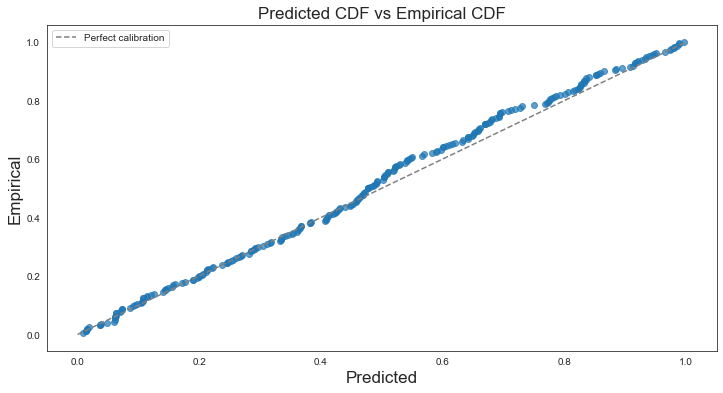

In [8]:
a, b, c = trace['a'][:-1000], trace['b'][:-1000], trace['c'][:-1000]

# fitting the calibrated regressor
pp_params = {'a': a, 'b': b, 'c': c, 'sigma':2}
calib = CalibratedRegression(X, y, model_correct, pp=posterior_predictive, pp_params=pp_params).fit()

# creating the results dataframe
df_results, pred_cdf, emp_cdf = calib.create_calibration_dataset()
display(df_results.head())

# getting quantiles
quants = [0.05, 0.5, 0.95]

# plotting calibration curve
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
calib.plot_calibration_curve(ax);

We see, from the plot above, that the model is very well calibrated by default, as it is correctly specified. We have already fit an Isotonic Regression to the above plot, when we called the `fit` function of our `CalibratedRegression` class, and we see the results of calibration in the following plot: 

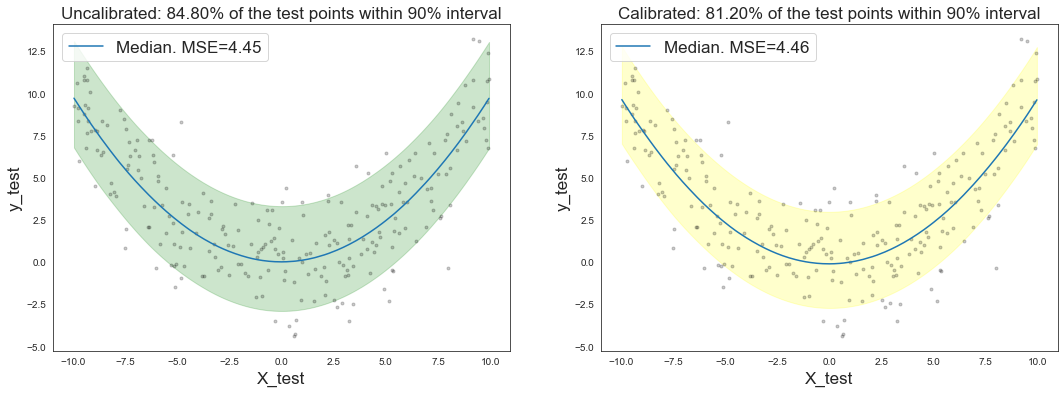

In [9]:
# checking new posterior predictive intervals
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
calib.plot_intervals(ax, X_test, y_test, quantiles=[0.05, 0.5, 0.95]);

After calibration, the resulting intervals, the percentage of points in the 90% interval and the MSE are similar. It appears as though the calibration model has overfit to the training data. One solution for this is to use **K-fold cross validation** and then average the predictions of the K-folds when creating an Isotonic Regression model. In fact, the calibrated model is slightly worse. The diagnostic plot recommended by the authors is shown below

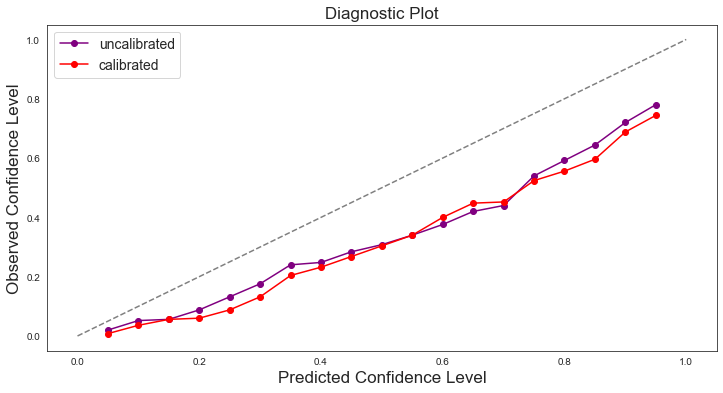

In [20]:
fig, ax = plt.subplots(1,1,figsize=(12,6))
calib.plot_diagnostic_curve(ax, X_test, y_test);

**Evaluation:** In this situation, when the model has already been perfectly specified, calibrating does not provide any additional advantages. 

<a id='experiment3'></a>
#### Experiment 3: Calibrating under epistemic uncertainty

In the first two experiments, the primary source of uncertainty was aleatoric uncertainty: randomness in the data generation process itself. Although the authors do not explicitly mention it, we also want to test this approach on epistemic uncertainty, which is caused by a lack of data. 

TODO

<a id='experiment4'></a>
#### Experiment 4: Calibrating when the training data differs from the test data (dataset shift)

Lakshminarayanan et al. [2] posit that the primary sources of miscalibration of uncertainties in models are model misspecification and dataset shift. In a time-series setting, a model may be trained on historical data whereas test data from a future time-period may not be similarly distributed. In this scenario, it is important to be able to still produce calibrated uncertainty estimates. In this experiment, we add bias to the test data such that it differs from the training data. In this experiment, we first generate a set of 1500 points (1250 training and 250 points) of the following form: 

$$
\begin{aligned}
x &\in [-10,10] \\
y_{train} &= p x^2 + \epsilon, \epsilon \sim \mathcal{N}(0,1) \\
y_{test} &= p x^2 + 1 + \epsilon, \epsilon \sim \mathcal{N}(0,1)
\end{aligned}
$$

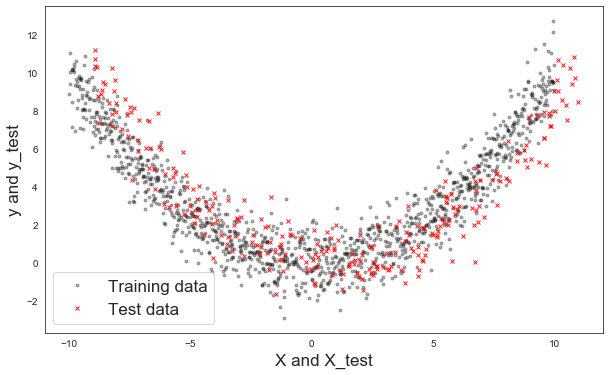

In [13]:
X, X_test, y, y_test = load_quadratic_data(scale=1)
dif = 1
X_test += dif

# plotting X and y and X_test and y_test
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
ax.set_xlabel('X and X_test', fontsize=17)
ax.set_ylabel('y and y_test', fontsize=17)

ax.plot(X, y, 'o', markersize=3, color='black', alpha=0.3, label='Training data')
ax.plot(X_test, y_test, 'x', markersize=4, color='red', alpha=0.9, label='Test data')
ax.legend(fontsize=17)
ax.set_xlim(-11, 11+dif);

Our model is correctly specified. We create the calibration dataset according to Algorithm 1 of the paper and plot the predicted cumulative distribution versus the empirical cumulative distribution as follows: 

In [15]:
with pm.Model() as model_shift:
    a = pm.Normal('a', mu=0, sigma=1)
    b = pm.Normal('b', mu=0, sigma=1)
    c = pm.Normal('c', mu=0, sigma=1)
    
    f = a*X**2 + b*X + c
    y_obs = pm.Normal('y', mu=f, sigma=1, observed=y)
    
    trace = pm.sample(1000, tune=1000)
    
pm.summary(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [c, b, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1030.54draws/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,0.099485,0.000932,0.000031,0.097702,0.101264,843.623442,0.999983
b,-0.001046,0.004798,0.000120,-0.010554,0.007898,1561.802544,0.999601
c,-0.010352,0.042206,0.001335,-0.096201,0.063419,935.788572,1.000375


,X,y,predicted_cdf,empirical_cdf
0,5.183456,5.026231,0.990,0.996
1,7.678452,4.340758,0.061,0.052
2,5.557038,3.158479,0.550,0.528
3,9.239493,7.561144,0.180,0.164
4,-7.811875,4.708009,0.084,0.060


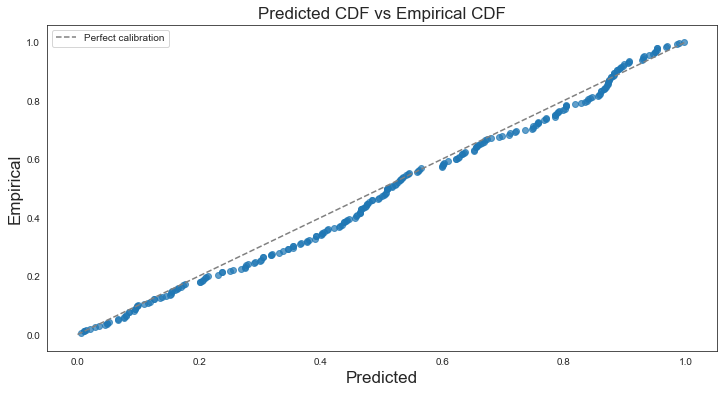

In [17]:
a, b, c = trace['a'][:-1000], trace['b'][:-1000], trace['c'][:-1000]

# fitting the calibrated regressor
pp_params = {'a': a, 'b': b, 'c': c, 'sigma':1}
calib = CalibratedRegression(X, y, model_shift, pp=posterior_predictive, pp_params=pp_params).fit()

# creating the results dataframe
df_results, pred_cdf, emp_cdf = calib.create_calibration_dataset()
display(df_results.head())

# getting quantiles
quants = [0.05, 0.5, 0.95]

# plotting calibration curve
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
calib.plot_calibration_curve(ax);

We see, from the plot above, that the model is very well calibrated by default, as it is correctly specified. We have already fit an Isotonic Regression to the above plot, when we called the `fit` function of our `CalibratedRegression` class, and we see the results of calibration in the following plot: 

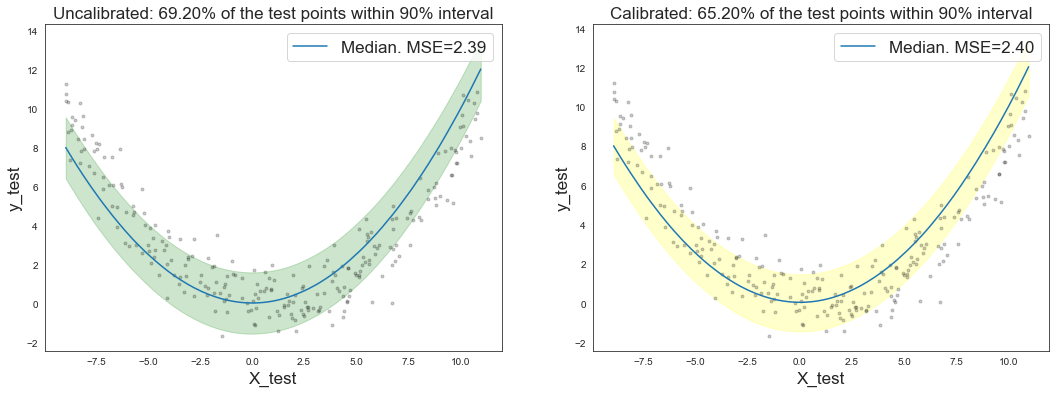

In [18]:
# checking new posterior predictive intervals
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
calib.plot_intervals(ax, X_test, y_test, quantiles=[0.05, 0.5, 0.95]);

After calibration, the resulting intervals, the percentage of points in the 90% interval and the MSE are similar. Calibration in this scenario does not fix the dataset shift problem. This is because the calibration dataset used is a subset of the training set, and the Isotonic Regression model is fit on this data. Therefore, it is not correctly calibrated on the test data which is slightly different from the training data. 

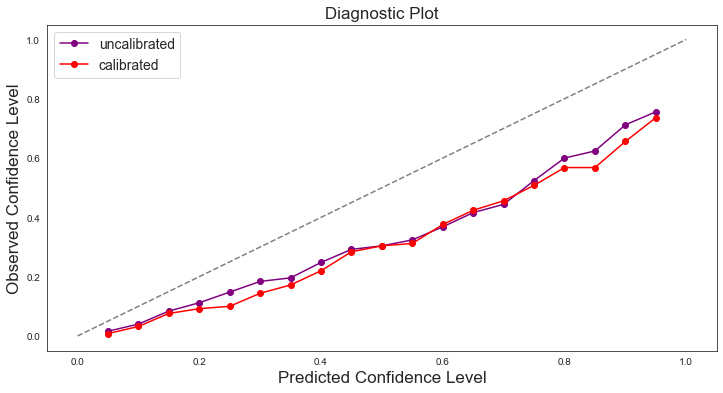

In [19]:
fig, ax = plt.subplots(1,1,figsize=(12,6))
calib.plot_diagnostic_curve(ax, X_test, y_test);

**Evaluation:** In this situation, the diagnostic curves for the calibrated model and the uncalibrated model are similar and are both far from the ideal calibration level. This clearly indicates that correct calibration on the training set does not equate to correct calibration on the test set, and that this method of calibration does not deal with dataset shift.

<a id='future_work'></a>
### Future Work

---

One useful concept that the authors introduce is sharpness. Sharpness is akin to how useful the predictive interval is, i.e., how wide it is. If it is excessively wide, it does not allow for meaningful inference even if it is technically well-calibrated. Sharpness is a very relevant criteria for many practitioners. While having well-calibrated uncertainty estimates is important, what good is a machine learning model in weather forecasting if the temperature tomorrow is forecasted to be between 0 and 100 degrees Fahrenheit?

Yet, the authors largely do not discuss how a predictive interval can be made sharper. The only reference they make to directly improving a model’s sharpness is in their discussion of additional features that could be used for recalibration. They suggest that additional features beyond $[H(x_t)](y_t)$ could be used as inputs to the recalibration step to improve sharpness. 

![Calibrated vs Sharp](images/calibrated_vs_sharp.png)

Many practitioners would be interested in creating sharper predictive models in addition to better calibrated ones. Are there post-processing steps, like the one outlined in this paper, that could be used to make sharper predictions? Or is this only something that can be remedied through the model building process itself? Future work on this subject would be of great value and would intersect with discussions of the impacts of epistemic and aleatoric uncertainty on machine learning models.

<a id='references'></a>
### References

---

[1] Volodymyr Kuleshov, Nathan Fenner and Stefano Ermon. Accurate Uncertainties for Deep Learning Using Calibrated Regression. arXiv preprint arXiv: 1807.00263, 2018.

[2] Balaji Lakshminarayanan, Alexander Pritzel, and Charles Blundell. Simple and scalable predictive uncertainty estimation using deep ensembles. arXiv preprint arXiv:1612.01474, 2017.

[3] Yarin Gal, Jiri Hron, and Alex Kendall. Concrete dropout. In Advances in Neural Information Processing Systems, pages 3584– 3593, 2017.

[4] J. Platt. Probabilistic outputs for support vector machines and comparisons to regularized likelihood methods. Advances in Large Margin Classifiers, 10(3):61–74, 1999.

---